<a href="https://colab.research.google.com/github/basi506/fore/blob/main/forensicplynology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries (Colab usually already has these, but this guarantees no missing deps)
!pip -q install openpyxl joblib scikit-learn seaborn

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import joblib


In [ ]:
# Upload file to Colab session
from google.colab import files
uploaded_files = files.upload()

# Use the exact file name you uploaded
xlsx_name = "forensick.csv.xlsx"
sheet_name = "forensic_palynology_dataset"

df = pd.read_excel(xlsx_name, sheet_name=sheet_name)
print(df.head())
print("\nShape:", df.shape)

Saving forensick.csv.xlsx to forensick.csv (1).xlsx
   pollen_count  pollen_diversity  dominant_pollen_ratio  avg_temperature  \
0           162                10                   0.57             34.0   
1           225                14                   0.62             26.7   
2           132                 7                   0.44             34.8   
3           208                15                   0.47             25.5   
4           160                 8                   0.32             20.5   

   humidity wind_exposure  season scene_type surface_type evidence_source  \
0        67           Low  Summer     Indoor     Clothing        Clothing   
1        95           Low  Summer    Outdoor      Vehicle         Vehicle   
2        62          High  Summer    Outdoor         Soil          Weapon   
3        50          High  Winter     Indoor     Clothing          Weapon   
4        67           Low  Winter     Indoor       Weapon            Body   

  collection_method sa

In [ ]:
# Target column from your dataset
target_col = "environment_class"

# Basic cleaning (strip spaces in column names if any)
df.columns = [c.strip() for c in df.columns]

# Split X and y
X = df.drop(columns=[target_col])
y = df[target_col].astype(str)

In [ ]:
# Identify numeric vs categorical columns automatically
numeric_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['pollen_count', 'pollen_diversity', 'dominant_pollen_ratio', 'avg_temperature', 'humidity', 'storage_duration_hours', 'pollen_degradation_score', 'sample_integrity_score']
Categorical columns: ['wind_exposure', 'season', 'scene_type', 'surface_type', 'evidence_source', 'collection_method', 'sample_condition', 'contamination_risk_level', 'transfer_mechanism', 'suspected_movement_level']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (480, 18)
Test shape: (120, 18)


In [ ]:
models = {
    "logreg": LogisticRegression(max_iter=2000, n_jobs=None),
    "rf": RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ),
    "hgb": HistGradientBoostingClassifier(random_state=42)
}

results = {}
trained_pipelines = {}

for model_name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results[model_name] = acc
    trained_pipelines[model_name] = pipe

    print("\nModel:", model_name)
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))


Model: logreg
Accuracy: 0.16666666666666666
              precision    recall  f1-score   support

Agricultural       0.22      0.25      0.24        24
     Coastal       0.13      0.17      0.15        24
      Forest       0.24      0.21      0.22        24
       Rural       0.17      0.17      0.17        24
       Urban       0.05      0.04      0.05        24

    accuracy                           0.17       120
   macro avg       0.16      0.17      0.16       120
weighted avg       0.16      0.17      0.16       120


Model: rf
Accuracy: 0.175
              precision    recall  f1-score   support

Agricultural       0.21      0.25      0.23        24
     Coastal       0.23      0.21      0.22        24
      Forest       0.23      0.21      0.22        24
       Rural       0.12      0.12      0.12        24
       Urban       0.09      0.08      0.09        24

    accuracy                           0.17       120
   macro avg       0.18      0.18      0.17       120
weigh

Best model: rf
Best accuracy: 0.175


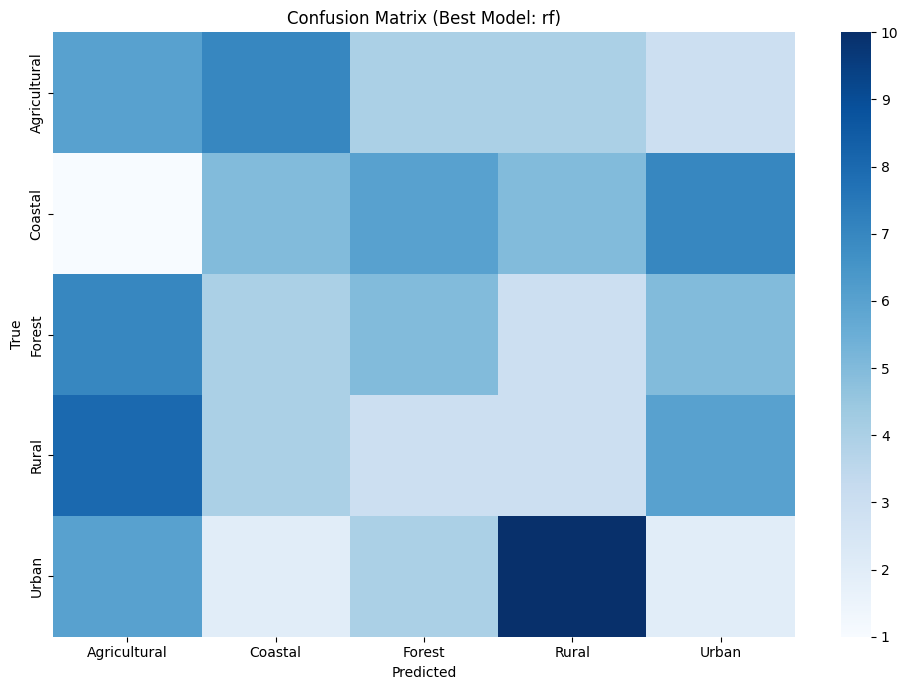

In [ ]:
best_model_name = max(results, key=results.get)
best_pipe = trained_pipelines[best_model_name]

print("Best model:", best_model_name)
print("Best accuracy:", results[best_model_name])

best_pred = best_pipe.predict(X_test)
cm = confusion_matrix(y_test, best_pred, labels=sorted(y.unique()))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.title("Confusion Matrix (Best Model: " + best_model_name + ")")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
model_out = "best_forensic_environment_classifier.joblib"
joblib.dump(best_pipe, model_out)

print("Saved model to:", model_out)

# Optional: download to your machine
from google.colab import files
files.download(model_out)

Saved model to: best_forensic_environment_classifier.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>